In [1]:


import requests
import pandas as pd
import math
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
from tqdm import tqdm



In [2]:
#get all experimental VP from SQL database
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import os
import json
import uuid

import rdkit
print(rdkit.__version__)
import lwreg
from lwreg import standardization_lib
from lwreg import utils
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'




2023.03.3


In [3]:
cn = psycopg2.connect(host=hostname, database=dbname, user=username)
cur = cn.cursor()
cur.execute('SELECT vp FROM cs_mdfps_schema.experimental_data')
#into df
df = pd.DataFrame(cur.fetchall())
df.columns = ['vp']
df

,vp
0,-0.758251
1,-3.580000
2,-5.309250
3,0.728915
4,-5.770647
...,...
3061,-6.770000
3062,3.457729
3063,2.397940
3064,-10.580632


In [4]:


data = df['vp']
output = [data]
for fold in (3,5,10):
    error = np.random.normal(0,np.log10(fold),len(data))
    output.append(error+data)
output_df = pd.DataFrame(output)
output_df = output_df.transpose()
output_df.columns = ["Experimental Vp","3-Fold","5-Fold","10-fold"]
output_df.head()



,Experimental Vp,3-Fold,5-Fold,10-fold
0,-0.758251,-0.024546,-0.739988,0.023611
1,-3.580000,-2.890572,-5.128628,-4.084861
2,-5.309250,-6.247446,-4.285885,-3.528960
3,0.728915,1.410229,1.037731,0.308877
4,-5.770647,-4.858059,-5.092363,-5.700629


In [5]:
df_melt = output_df.melt(id_vars="Experimental Vp")
df_melt.head()

,Experimental Vp,variable,value
0,-0.758251,3-Fold,-0.024546
1,-3.580000,3-Fold,-2.890572
2,-5.309250,3-Fold,-6.247446
3,0.728915,3-Fold,1.410229
4,-5.770647,3-Fold,-4.858059


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


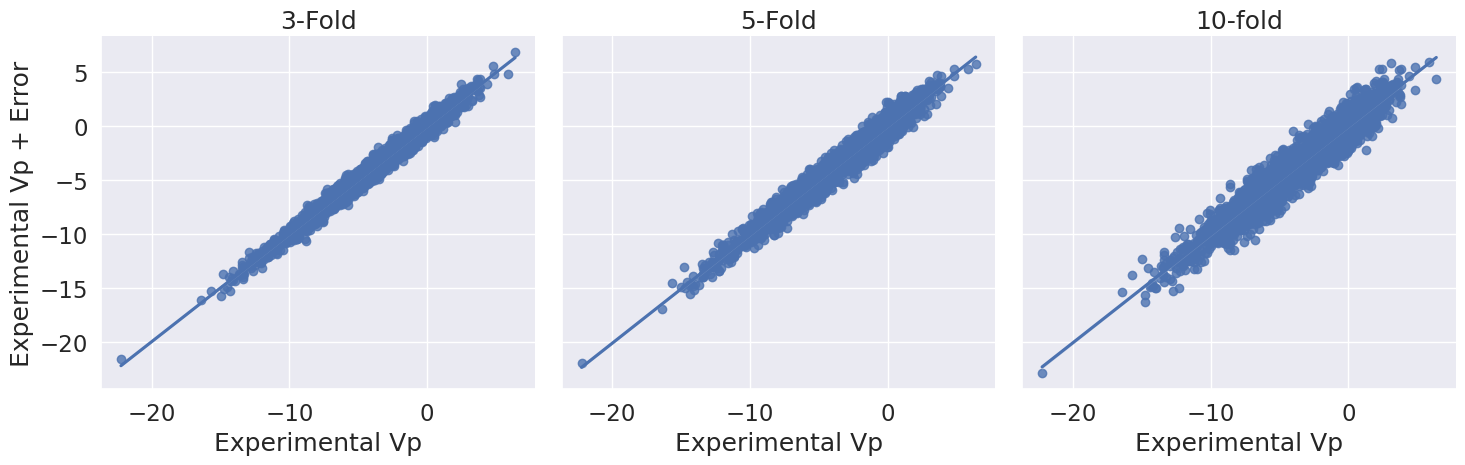

In [6]:
sns.set(font_scale=1.5)
g = sns.lmplot(x="Experimental Vp",y="value",col="variable",data=df_melt)
title_list = ["3-Fold","5-Fold","10-fold"]
for i in range(0,3):
    g.axes[0,i].set_ylabel('Experimental Vp + Error')
    g.axes[0,i].set_title(title_list[i])

100%|██████████| 3/3 [00:03<00:00,  1.02s/it]
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


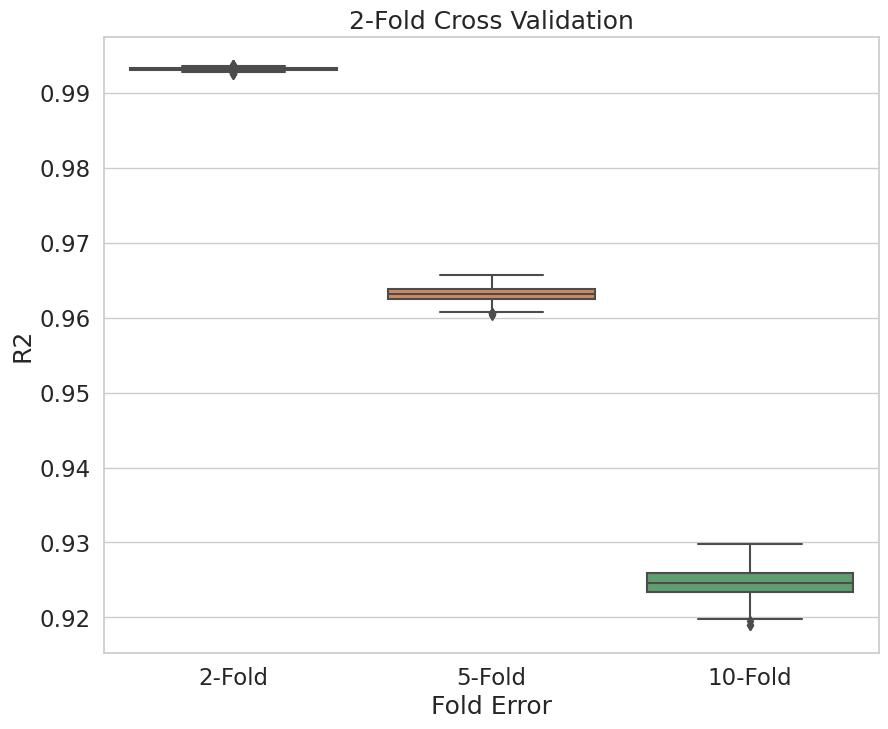

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


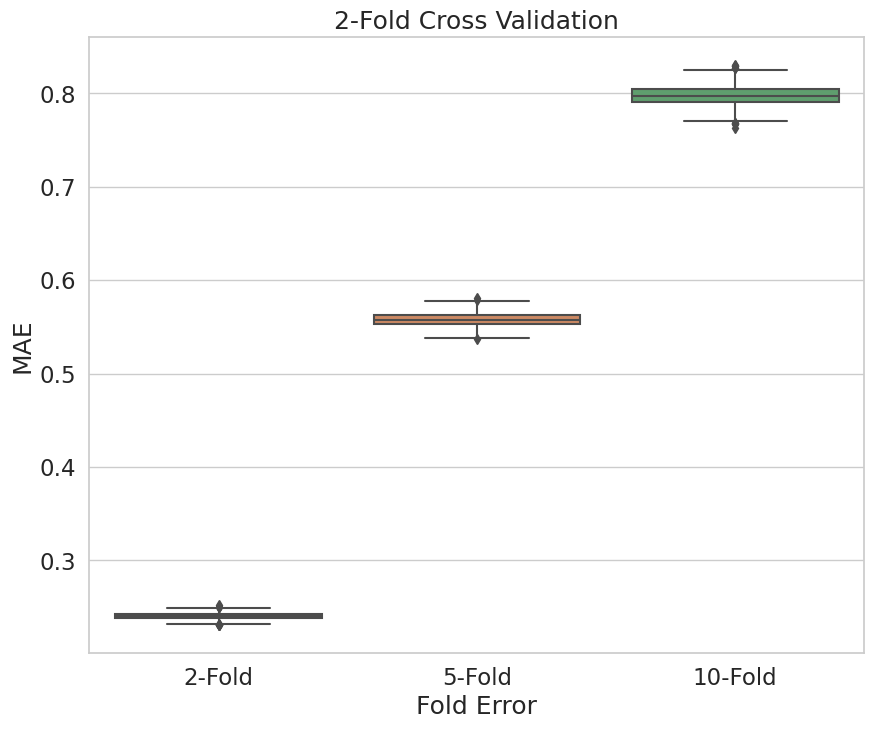

In [33]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

cor_list = []
mae_list,rmse_list = [],[]
for fold in tqdm([2,5,10]):
    for i in range(0,1000):
        error = np.random.normal(0,np.log10(fold),len(data))
        cor_list.append([r2_score(data,data+error),f"{fold}-Fold"])
        mae_list.append([mean_absolute_error(data,data+error),f"{fold}-Fold"])
        rmse_list.append([mean_squared_error(data,data+error,squared=False),f"{fold}-Fold"])
error_df = pd.DataFrame(cor_list,columns=["r2","fold_error"])
error_df.head()
mae_df = pd.DataFrame(mae_list,columns=["mae","fold_error"])
mae_df.head()
rmse_df = pd.DataFrame(rmse_list,columns=["rmse","fold_error"])
rmse_df.head()
#boxplot of distribution of r2 values, mae and rmse for 2-fold




In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

cor_list = []
mae_list,rmse_list = [],[]
for fold in tqdm([2,5,10]):
    for i in range(0,1000):
        error = np.random.normal(0,np.log10(fold),len(data))
        cor_list.append([r2_score(data,data+error),f"{fold}-Fold"])
        mae_list.append([mean_absolute_error(data,data+error),f"{fold}-Fold"])
        rmse_list.append([mean_squared_error(data,data+error,squared=False),f"{fold}-Fold"])
error_df = pd.DataFrame(cor_list,columns=["r2","fold_error"])
error_df.head()
mae_df = pd.DataFrame(mae_list,columns=["mae","fold_error"])
mae_df.head()
rmse_df = pd.DataFrame(rmse_list,columns=["rmse","fold_error"])
rmse_df.head()
#boxplot of distribution of r2 values, mae and rmse for 2-fold



/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


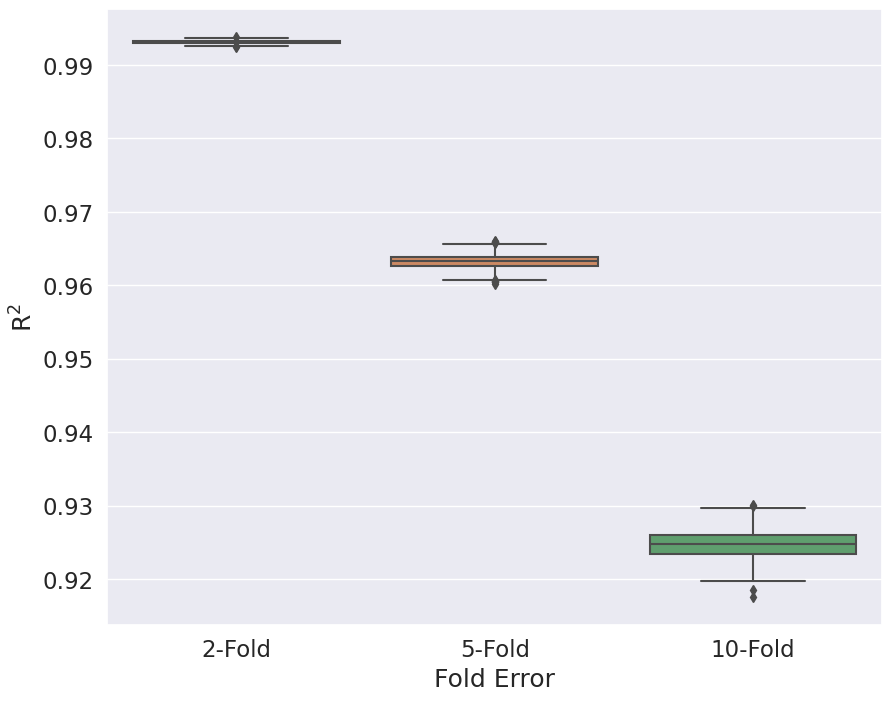

In [28]:


sns.set(rc={'figure.figsize': (10, 8)},font_scale=1.5)
ax = sns.boxplot(x="fold_error",y="r2",data=error_df)
_ = ax.set(xlabel="Fold Error",ylabel="R$^2$")



/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


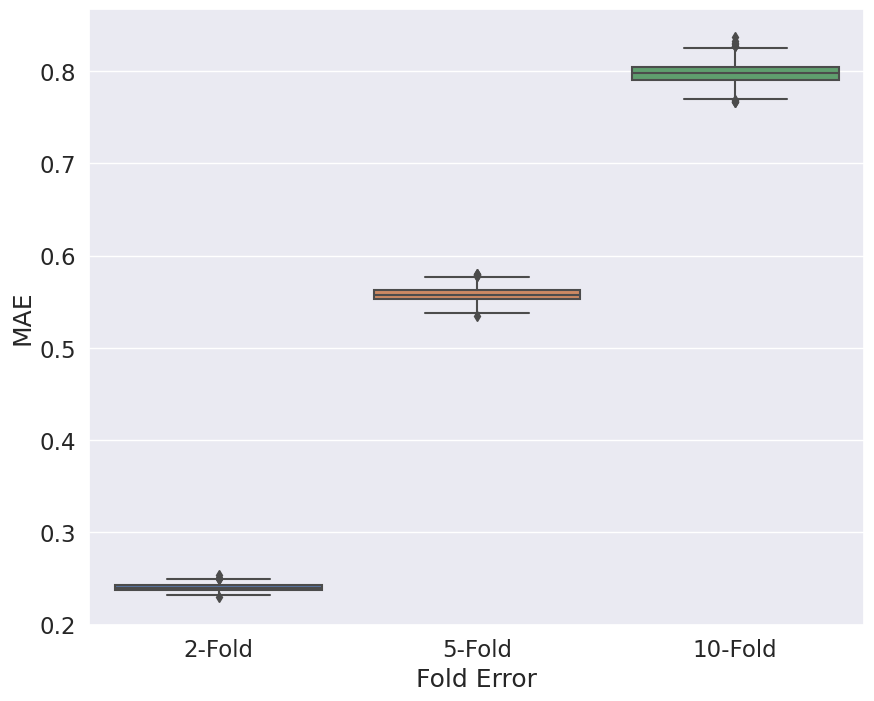

In [25]:
sns.set(rc={'figure.figsize': (10, 8)},font_scale=1.5)
ax = sns.boxplot(x="fold_error",y="mae",data=mae_df)
_ = ax.set(xlabel="Fold Error",ylabel="MAE")




/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


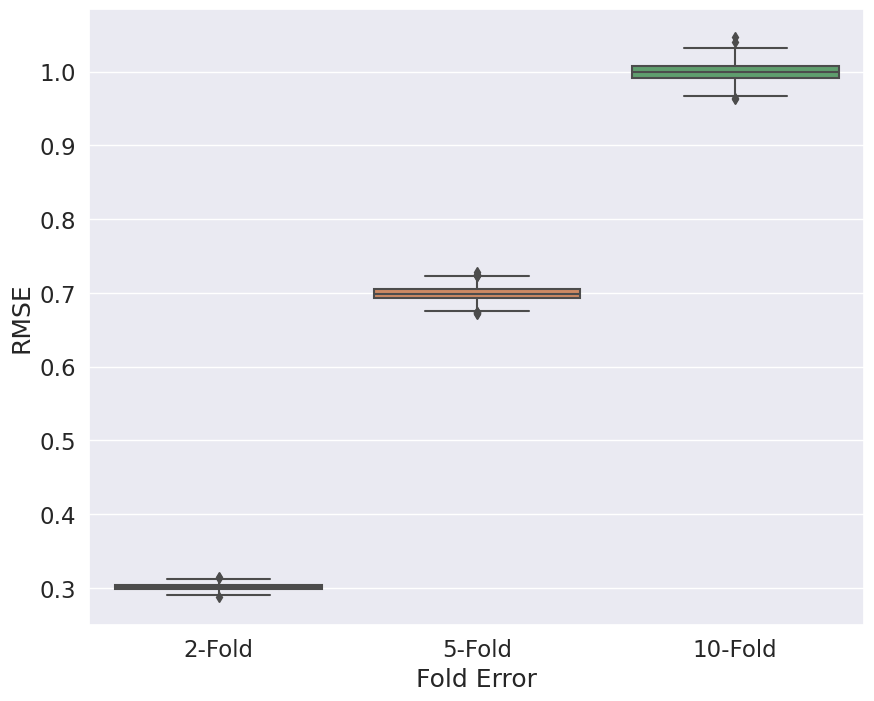

In [26]:
sns.set(rc={'figure.figsize': (10, 8)},font_scale=1.5)
ax = sns.boxplot(x="fold_error",y="rmse",data=rmse_df)
_ = ax.set(xlabel="Fold Error",ylabel="RMSE")

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


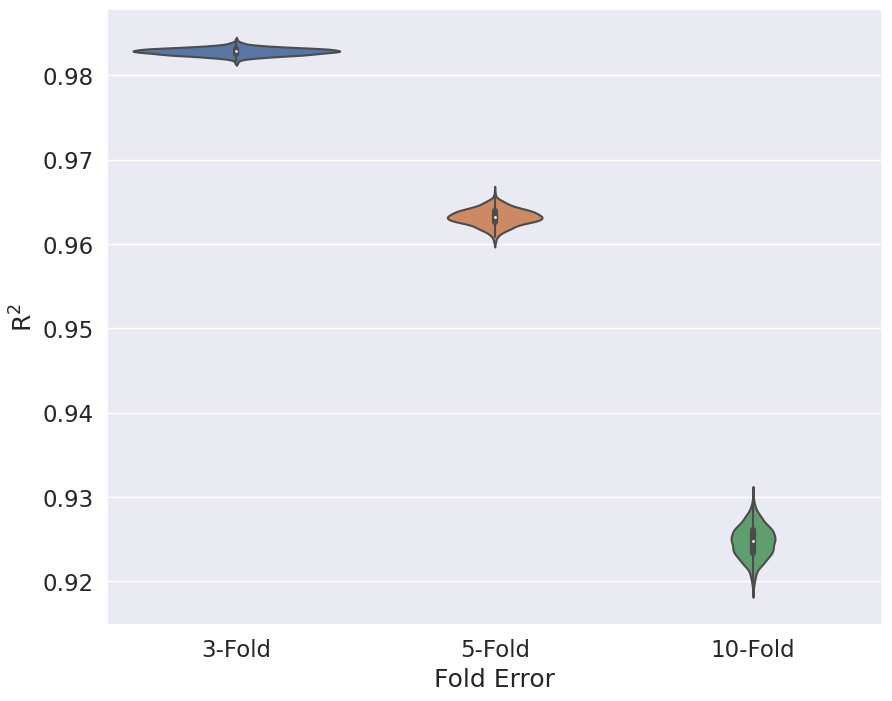

In [9]:
sns.set(rc={'figure.figsize': (10, 8)},font_scale=1.5)
ax = sns.violinplot(x="fold_error",y="r2",data=error_df)
_ = ax.set(xlabel="Fold Error",ylabel="R$^2$")

In [10]:
import pandas as pd
from rdkit import Chem
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

val_list = []
for i in [0.17,0.5,0.6,1.0]:
    for j in range(0,10000):
        val = np.random.choice(df.vp.values)
        err = np.random.normal(0,i)
        val_list.append([i,val,val+err])
val_df = pd.DataFrame(val_list,columns=["sd","val","err"])

#For this example, the total combined uncertainty Uc,95.45% is calculated to be 4.2 mPa --> convert to log kPa
uncertainty_paper = 4.2

In [11]:


label_list = []
for k,v in val_df.groupby("sd"):
    r = pearsonr(v.val,v.err).statistic
    MAE = mean_absolute_error(v.val,v.err)
    RMSE = np.sqrt(mean_squared_error(v.val,v.err))
    label = f"r = {r:.02f} \nMAE = {MAE:.02f} \nRMSE = {RMSE:.02f}"
    label_list.append(label)



/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


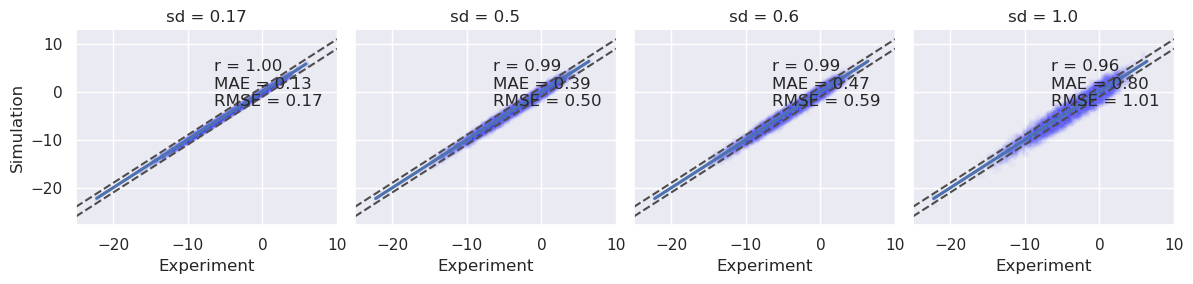

In [12]:


sns.set_context('notebook')
g = sns.lmplot(x="val",y="err",col="sd",data=val_df, height=3,
           scatter_kws=dict(alpha=0.02, s=20, color='blue', edgecolors='white'))
g.set_xlabels("Experiment")
g.set_ylabels("Simulation")
for ax,label in zip(g.axes[0],label_list):
    ax.text(-6.5, -3, label)
    #add diagonal with offset 1
    ax.plot([-25, 10], [-25+1, 10+1], ls="--", c=".3")
    ax.plot([-25, 10], [-25-1, 10-1], ls="--", c=".3")

    ax.set_xlim(-25,10)



In [16]:
df

,vp
0,-0.758251
1,-3.580000
2,-5.309250
3,0.728915
4,-5.770647
...,...
3061,-6.770000
3062,3.457729
3063,2.397940
3064,-10.580632
